# Классификация знаков дорожного движения

## Импорты

Чтобы не перезапускать ноутбук, если меняются .py файлы

In [1]:
%load_ext autoreload
%autoreload 2

Чтобы импортировать функции из нашего модуля

In [2]:
import sys
sys.path.append('../')

Нужные импорты

In [3]:
from os import path as osp
from typing import Tuple

import cv2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from pipeline.constants import DEFAULT_DATA_PATH, DEFAULT_EXPERIMENTS_SAVE_PATH
from pipeline.dataset import read_rgb_img
from pipeline.generate_submission import get_and_save_test_result, get_submission_filename
from pipeline.train import train

## Функции для визуализации

In [4]:
def plot_image_from_row(row: pd.Series, figsize: Tuple[int, int] = (10, 10)) -> None:
    img_path = osp.join(DEFAULT_DATA_PATH, row.filename)
    img = read_rgb_img(img_path)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img)


def plot_image_with_label_from_row(row: pd.Series, figsize: Tuple[int, int] = (10, 10)) -> None:
    print(f'Label: {row["label"]}')
    plot_image_from_row(row, figsize)

## Посмотрим на тренировочные данные

In [5]:
df = pd.read_csv(osp.join(DEFAULT_DATA_PATH, 'train.csv'))

/home/m.liz/anaconda3/envs/skoltech_newenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


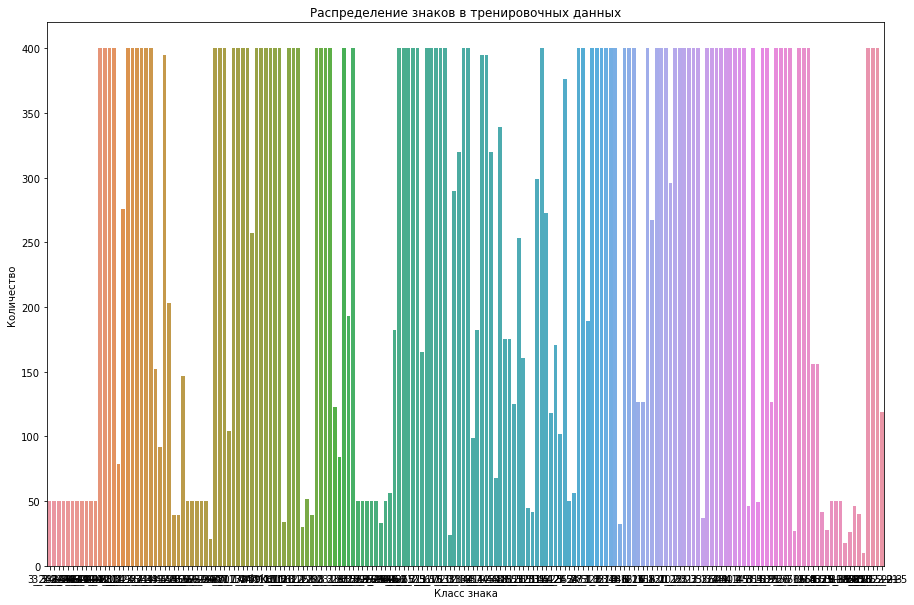

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_title('Распределение знаков в тренировочных данных')
sns.countplot(df.label, ax=ax)
ax.set_xlabel('Класс знака')
ax.set_ylabel('Количество');

Визуализация знаков из тренировочного датасета

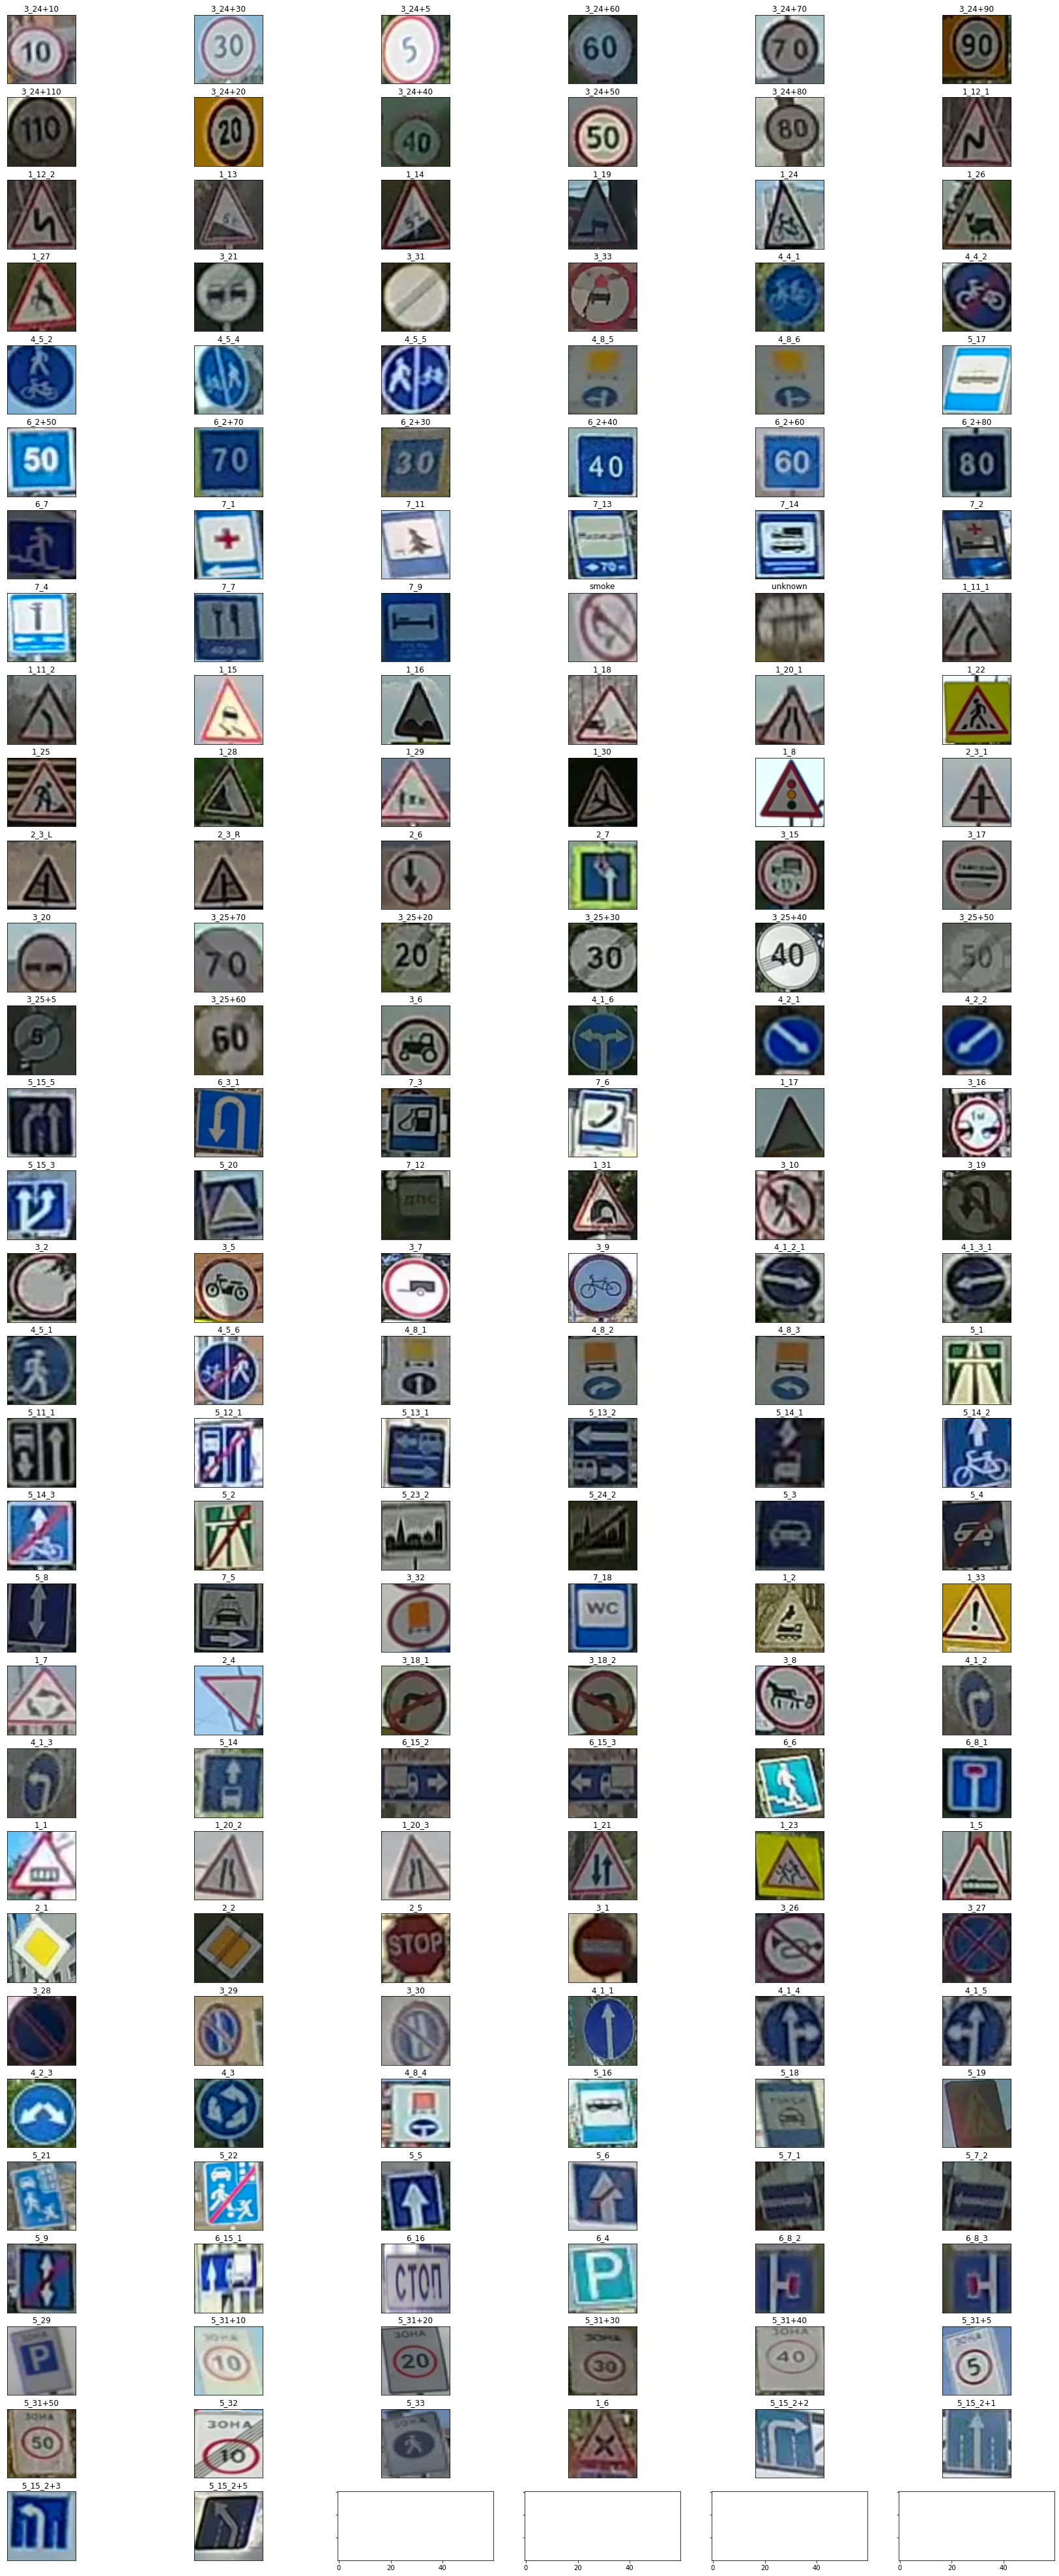

In [7]:
cols = 6

labels = df['label'].unique()
rows = (len(labels) // cols) + 1

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(30, 70))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)

idx = 0
for i in range(rows):
    for j in range(cols):
        if idx >= len(labels):
            break
        
        row = df[df['label'] == labels[idx]].iloc[0]
        img = read_rgb_img(osp.join(DEFAULT_DATA_PATH, row.filename))
        img = cv2.resize(img, (60, 60))

        axs[i, j].imshow(img)
        axs[i, j].set_facecolor('xkcd:salmon')
        axs[i, j].set_facecolor((1.0, 0.47, 0.42))
        axs[i, j].set_title(labels[idx])
        axs[i, j].get_xaxis().set_visible(False)
        axs[i, j].get_yaxis().set_visible(False)
        idx += 1

## Обучим модель

In [8]:
experiment_name = 'baseline'
model_name = 'resnet18'
n_epochs = 5
batch_size = 64
device = 'cuda:0'

In [9]:
train_metrics, valid_metrics = train(experiment_name, model_name, n_epochs, batch_size, device)

Epoch 0 training: 100%|██████████| 648/648 [00:21<00:00, 30.29it/s, loss=0.008794]


Epoch 0: train_f1=0.8606; train_loss=0.008794


Epoch 0 evaluating: 100%|██████████| 72/72 [00:00<00:00, 87.84it/s, loss=0.002510]


Epoch 0: val_f1=0.9351; val_loss=0.002510
Model saved!


Epoch 1 training: 100%|██████████| 648/648 [00:20<00:00, 31.82it/s, loss=0.000862]


Epoch 1: train_f1=0.9802; train_loss=0.000862


Epoch 1 evaluating: 100%|██████████| 72/72 [00:00<00:00, 87.82it/s, loss=0.001034]


Epoch 1: val_f1=0.9733; val_loss=0.001034
Model saved!


Epoch 2 training: 100%|██████████| 648/648 [00:20<00:00, 31.42it/s, loss=0.000554]


Epoch 2: train_f1=0.9884; train_loss=0.000554


Epoch 2 evaluating: 100%|██████████| 72/72 [00:00<00:00, 90.68it/s, loss=0.000552] 


Epoch 2: val_f1=0.9881; val_loss=0.000552
Model saved!


Epoch 3 training: 100%|██████████| 648/648 [00:20<00:00, 31.84it/s, loss=0.000415]


Epoch 3: train_f1=0.9911; train_loss=0.000415


Epoch 3 evaluating: 100%|██████████| 72/72 [00:00<00:00, 87.01it/s, loss=0.000369]


Epoch 3: val_f1=0.9896; val_loss=0.000369
Model saved!


Epoch 4 training: 100%|██████████| 648/648 [00:20<00:00, 31.56it/s, loss=0.000425]


Epoch 4: train_f1=0.9910; train_loss=0.000425


Epoch 4 evaluating: 100%|██████████| 72/72 [00:00<00:00, 87.66it/s, loss=0.000663]


Epoch 4: val_f1=0.9852; val_loss=0.000663


Графики метрик на обучении

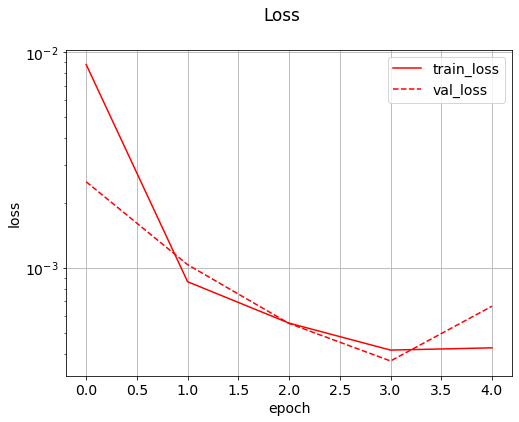

In [10]:
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Loss')

axes.plot(train_metrics['loss'], label='train_loss', color='r')
axes.plot(valid_metrics['loss'], label='val_loss', color='r', linestyle='dashed')

axes.set_xlabel('epoch')
axes.set_ylabel('loss')
axes.set_yscale('log')
axes.grid()
axes.legend()

plt.show()

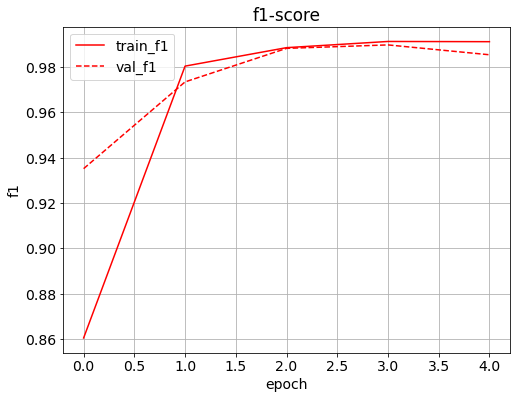

In [15]:
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title('f1-score')
ax.plot(train_metrics['f1'], label=f'train_f1', color='r')
ax.plot(valid_metrics['f1'], label=f'val_f1', color='r', linestyle='dashed')
ax.set_xlabel('epoch')
ax.set_ylabel('f1')
ax.grid()
ax.legend()

plt.show()

## Протестируем модель

In [16]:
test_results_df = get_and_save_test_result(experiment_name, model_name, batch_size, device)

Testing...: 100%|██████████| 95/95 [00:01<00:00, 93.99it/s] 


In [17]:
idx = -1

Label: 5_19


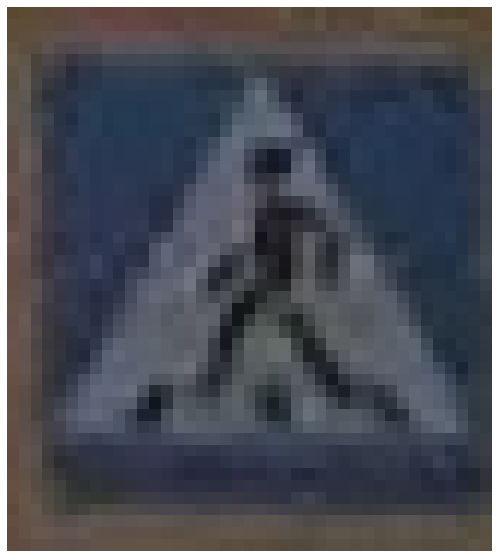

In [21]:
idx += 1
row = test_results_df.iloc[idx]

plot_image_with_label_from_row(row)